In [1]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import RFE
import sklearn.feature_selection
import xgboost as xgb
from sklearn.metrics import roc_auc_score

from numpy import loadtxt
from xgboost import plot_importance
from matplotlib import pyplot

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
raw = pd.read_csv("raw.csv")

In [3]:
usedColumns = ['CIGEVER','ALCEVER','MJEVER', 'COCEVER', 'HEREVER', 'BOOKED', 'DRIVALC2']
usedFeatures = ['CIGEVER','ALCEVER','MJEVER', 'COCEVER', 'HEREVER', 'DRIVALC2']

selection = raw[usedColumns]

selection.is_copy = False


selection[selection == 2] = 0
selection[selection == 4] = 0
selection[selection == 3] = 1
selection[selection == 85] = 0
selection[selection == 94] = 0
selection[selection == 97] = 1 #Refused to answer = yes
selection[selection == 98] = 1 #Left blank = yes

s_train, s_test = train_test_split(selection, train_size = 0.8)
train, test = train_test_split(raw, train_size = 0.8)

Y_train = s_train[['BOOKED']]
Y_test = s_test[['BOOKED']]

X_train = s_train[usedFeatures]
X_test = s_test[usedFeatures]

X_train.head()

,CIGEVER,ALCEVER,MJEVER,COCEVER,HEREVER,DRIVALC2
6417,1,0,1,0,0,0
3633,0,1,0,0,0,0
15242,0,1,0,0,0,0
28195,0,1,0,0,0,1
48051,0,0,0,0,0,0


In [4]:
model = xgb.XGBRegressor(objective="binary:logistic")

In [5]:
model.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [6]:
predictions = model.predict(X_test)
roc_auc_score(Y_test, predictions)

0.78297754482049653

Feature Selection

In [7]:
# estimator = SVR(kernel="linear")
# selector = RFE(estimator, 5, step=1)
# selector = selector.fit(X_train, Y_train)

# selector.ranking_

Predictive Power Ranking:
1) Heroin
2) Cigarettes
3) Drinking and Driving
4) Alcohol
5) Marijuana
6) Cocaine

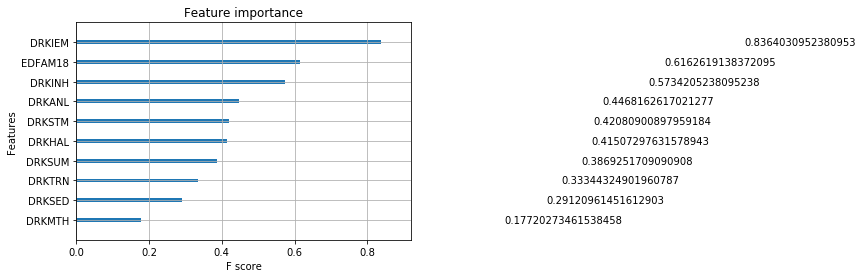

In [13]:
plot_importance(model, importance_type='gain')
pyplot.show()

In [25]:
iterations = 500
sliceIndex = int(3000/iterations)
feats= []
threshold = int(len(X_train)*.3)
count = 0

for i in range(1,iterations):
    X_train = train.iloc[:,list(range((i-1)*sliceIndex,i*sliceIndex))]
    model.fit(X_train, Y_train)
    rankings = model.booster().get_score(importance_type='gain')

    for key,value in rankings.items():
        if value > .8:
            counts = X_train[key].value_counts()
            try:
                condition1 = counts[99] < threshold
            except KeyError:
                try:
                    condition1 = counts[999] < threshold
                except KeyError:
                    try:
                        condition1 = counts[9999] < threshold
                    except:
                        condition1 = True
                        
            try:
                condition2 = counts[98] < threshold
            except KeyError:
                try:
                    condition2 = counts[998] < threshold
                except KeyError:
                    try:
                        condition2 = counts[9998] < threshold
                    except:
                        condition2 = True
                        
            if(condition1 and condition2):
                print(str(count) + key)
                feats.append([key, value])
                if value > 300:
                    print('!^^^^!')
        count = count + 1

0CASEID
1QUESTID2
3CIGEVER
5CIGTRY
7CIGREC
8CIG30AV
11CIG30USE
13CIG30MEN
17CIGDLYMO
18SNFEVER
21CIGAGE
23SNUFTRY
25SN30EST
26SNF30BR2
27SNUFYFU
29SNF30USE
30CHEWTRY
31CHEWREC
32CHEWYFU
33CHEWMFU
35CH30EST
36CHW30BR2
37SLTTRY
38SLTREC
39SLTYFU
40SLTMFU
41SLT30BR2
42SLT30FAV
43CIGARTRY
45CIGARYFU
46CIGARMFU
54ALCREC
55ALCTRY
56ALCEVER
58ALCYRTOT
67DR5DAY
68ALCDAYS
69NODR30A
71MJREC
72MJAGE
73MJYRTOT
76MRDAYPWK
78MRDAYPYR
81MJDAY30A
82COCREC
83COCEVER
84COCYFU
87COCMFU
93COCUS30A
104CR30EST
126HALNEWC
127HALNOLST
129HALNEWD
130HALNEWA
132HALLREC
134HALYFU
136HALNEWE
137HALMFU
143LSDMFU
145HAL30USE
148HL30EST
155ECSMFU
160GAS
171INHYRTOT
173INHYFU
175INHREC
212ANALYFU
213ANALMFU
216ANLYRTOT
217ANALAGE
223OXYCAGE
224OXYCREC
264TRDAYPYR
284STIMNEWD
287STIMMFU
295STDAYPMO
298METHYFU
322SEDYFU
401IIALCFY
402IRALCFY
403IRMJFY
406IIMJFY
408IICOCFY
415IIINHFY
418II2HALFY
426IRTRNFY
428IISTMFY
430IRSTMFY
442IICGRFM
443IRCGRFM
444IRSNFFM
445IRALCFM
447IISNFFM
449IICHWFM
450IIALCD5
451IRALCD5
452II

In [32]:
feats.sort(key=lambda x: x[1], reverse=True)

In [44]:
lst2 = [item[0] for item in feats]
lst2.remove('CASEID')
lst2.remove('QUESTID2')

In [46]:
lst2[:100]

['IISNFAGE',
 'IICDUAGE',
 'CIGARYLU',
 'IISLTYFU',
 'CDCGMO',
 'CIGTRY',
 'IICGRAGE',
 'IIMTHAGE',
 'BMI2',
 'HPDRGTLK',
 'SUMYR',
 'CIGEVER',
 'TRIMEST',
 'DCIGMON',
 'HPUSEALC',
 'SNFEVER',
 'COCYLU',
 'IISLTAGE',
 'IISTMAGE',
 'IRSLTAGE',
 'IICGCRV',
 'ADPBNUM',
 'CDNOCGMO',
 'IICGRYFU',
 'YOPBNUM',
 'ADPSDAYS',
 'WHODASC3',
 'TRANMLU',
 'ECSMLU',
 'CIGINCRS',
 'ANALYLU',
 'PREG2',
 'IICD2YFU',
 'CIGARMLU',
 'RK5ALDLY',
 'CDUFLAG',
 'WTPOUND2',
 'IIALCYFU',
 'IRCGRAGE',
 'MRJAGLST',
 'INHYLU',
 'IIINHAGE',
 'IIMJAGE',
 'IRALCAGE',
 'IITRNAGE',
 'CIGAVGM',
 'IRMJAGE',
 'MVIN5YR2',
 'IISNFYFU',
 'SMIPP_U',
 'IRSNFAGE',
 'IRLSDAGE',
 'IRALCYFU',
 'SUMAGE',
 'MJAGE',
 'HALMLU',
 'ANALYFU',
 'CHEWYLU',
 'SNUFMLU',
 'CGRAGLST',
 'COCAGLST',
 'NMVSOPT2',
 'CPNPSYYR',
 'IILSDAGE',
 'IICHWAGE',
 'IRMTHAGE',
 'ALCYRTOT',
 'IRCRKAGE',
 'RKCOCREG',
 'CHWAGLST',
 'ALCEVER',
 'IICGRFM',
 'IIALCFY',
 'CIGAGLST',
 'ALCTRY',
 'STIMYLU',
 'SNFAGLST',
 'CIGFNSMK',
 'CPNPSYMN',
 'SCHFELT',
 'CIG30MEN'